In [1]:
import numpy as np

from tvolib import mpl_utils as mu

from rls.simulation import Simulation
from rls.models import WhistlerAtGradientModel
from rls.formula.conversions import cartesian_to_FAC

sim = Simulation(model=WhistlerAtGradientModel(
    Bw=0.05, w_wce=0.05, sw=1.75, Bh=-0.8, B0=-1.0, theta=0.0,
))
model = sim.model
units = model.units

c = units.c
R = model.R
B0 = model.B0
Bw = model.Bw
w_wce = model.w_wce
theta = model.theta
sw = model.sw
qe = units.electron.q
me = units.electron.m
wpe0 = units.electron.wp(model.n0, units.eps0)
wce0 = units.electron.wc(model.B0)
V_factor = (units.L_factor / units.T_factor).to("1000 km/s")
W_factor = units.W_factor

In [2]:
sim.name = "fig_setup_IC_array"
sim.load_data()

t = sim.solutions.t[:]
g, x, y, z, ux, uy, uz = sim.solutions.as_tuple() 
tg = t[:, np.newaxis] * np.ones_like(x)

args = model.background_field_args
_, _, _, B0_x, _, B0_z = model.background_field(tg, x, y, z, *args)
wce = np.abs(qe.code / me.code * np.sqrt(B0_x**2 + B0_z**2))
w, k = model.dispersion_relation(wce, w_wce, wpe0.code, c.code)
V_para, V_perp, W, A = cartesian_to_FAC(g, ux, uy, uz, B0_x, B0_z, model)
W0 = W[0, :]
dW = W - W0[np.newaxis, :]
particle_colors = mu.plt.cm.jet(np.linspace(0, 1, Np := W0.size))

V_perp_arr = np.linspace(0, 0.03, 1000) * c.code
z_arr = np.linspace(-3, 3, 1000) * R.code
B0_z_arr = B0.code * model.eta(z_arr, *model.background_field_args)
wce_arr = np.abs(qe.code / me.code * B0_z_arr)
Vr_arr = model.resonant_velocity(wce_arr, w_wce, wpe0.code, c.code)
trap_angle = np.degrees(np.arcsin(np.sqrt(B0_z_arr / B0.code)))

data_array = dict(
    z=z,
    V_para=V_para,
    V_perp=V_perp,
    dW=dW,
    A=A,
    z_arr=z_arr,
    Vr_arr=Vr_arr,
    B0_z_arr=B0_z_arr,
    trap_angle=180 - trap_angle,
    Np=Np,
    particle_colors=particle_colors,
)

In [3]:
sim.name = "fig_setup_IC_random"
sim.load_data()

t = sim.solutions.t[:]
g, x, y, z, ux, uy, uz = sim.solutions.as_tuple() 
tg = t[:, np.newaxis] * np.ones_like(x)

args = model.background_field_args
_, _, _, B0_x, _, B0_z = model.background_field(tg, x, y, z, *args)
wce = np.abs(qe.code / me.code * np.sqrt(B0_x**2 + B0_z**2))
w, k = model.dispersion_relation(wce, w_wce, wpe0.code, c.code)
V_para, V_perp, W, A = cartesian_to_FAC(g, ux, uy, uz, B0_x, B0_z, model)
Vi_para = V_para[0, :]
Vi_perp = V_perp[0, :]
dW = W[-1, :] - W[0, :]
dA = A[-1, :] - A[0, :]
dW_max = np.abs(dW.user).max().value
dA_max = np.abs(dA.user).max().value

resonant_particles = dA.user < 0
V_para_arr = np.linspace(-25, 0, 200) * V_factor.user.unit
H = np.histogram(
    Vi_para[resonant_particles].user,
    bins=V_para_arr
)[0]
H_dW = np.histogram(
    Vi_para[resonant_particles].user,
    weights=dW[resonant_particles].user,
    bins=V_para_arr,
)[0]
H_dA = np.histogram(
    Vi_para[resonant_particles].user,
    weights=dA[resonant_particles].user,
    bins=V_para_arr,
)[0]
dW_mean = H_dW / H
dA_mean = H_dA / H

# B0c = model.eta(0.0, *model.background_field_args)
# wcec = np.abs(qe * B0c / me)
# wc, kc = model.dispersion_relation(wcec, w_wce, wpe0, c_)
# trap_angle = np.arcsin(np.sqrt(B0c))

data_random = dict(
    V_para=V_para_arr[:-1],
    dA_mean=dA_mean,
    dW_mean=dW_mean,
)

/home/tvo/.local/share/mamba/envs/rls/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


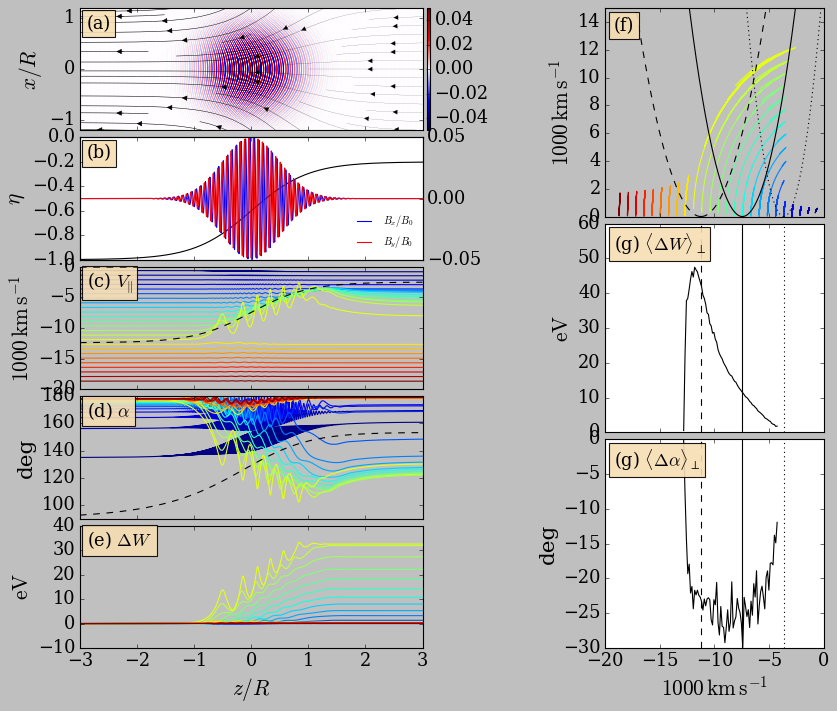

In [16]:
from rls.io import work_dir

fig = mu.plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(15, 3, width_ratios=(4.0, 1.0, 2.5))

# 2D domain
z = np.linspace(-3, 3, Nz := 1000) * R.code
x = np.linspace(-3, 3, Nx := 1000) * 0.4 * R.code
X, Z = np.meshgrid(x, z, indexing="ij")
Y = np.zeros_like(X)
_, _, _, B0_x, _, B0_z = model.background_field(
    0.0, X, Y, Z,
    *model.background_field_args
)
B0_mag = np.sqrt(B0_x**2 + B0_z**2)
Ew_x, Ew_y, Ew_z, Bw_x, Bw_y, Bw_z = model.wave_field(
    0.0, X, Y, Z, B0_x, B0_z,
    *model.wave_field_args,
)
ax_a = fig.add_subplot(gs[0:3, 0])
ax_a.streamplot(
    Z / R.code,
    X / R.code,
    B0_z,
    B0_x,
    linewidth=0.1 * B0_mag / B0_mag.min(),
    color="k",
    density=0.5,
)
im = ax_a.pcolormesh(
    Z / R.code,
    X / R.code,
    Bw_x / B0.code,
    cmap="seismic",
    vmin=-0.05,
    vmax=0.05,
)
cax = mu.add_colorbar(ax_a, size="1%")
fig.colorbar(im, cax=cax)
ax_a.set_xlim(z[0] / R.code, z[-1] / R.code)
ax_a.set_ylim(x[0] / R.code, x[-1] / R.code)
ax_a.set_xticklabels([])
ax_a.locator_params(axis="y", nbins=5)
ax_a.set_ylabel("$x/R$")
mu.add_text(ax_a, 0.02, 0.83, "(a)")

# 1D domain
ax_b_l = fig.add_subplot(gs[3:6, 0])
ax_b_r = ax_b_l.twinx()
ax_b_r.plot(Z[Nx // 2, :] / R.code, Bw_x[Nx // 2, :] / B0.code, "-b", label="$B_x/B_0$")
ax_b_r.plot(Z[Nx // 2, :] / R.code, Bw_y[Nx // 2, :] / B0.code, "-r", label="$B_y/B_0$")
ax_b_l.plot(Z[Nx // 2, :] / R.code, B0_mag[Nx // 2, :] / B0.code, "-k")
ax_b_l.set_ylabel("$\eta$")
for ax in [ax_b_r, ax_b_l]:
    mu.add_colorbar(ax, size="1%").remove()
    ax.set_xlim(z[0] / R.code, z[-1] / R.code)
    ax.set_xticklabels([])
    ax.locator_params(axis="y", nbins=5)
    
mu.add_text(ax_b_l, 0.02, 0.83, "(b)")
ax_b_l.set_ylim(-1.0, 0)
ax_b_r.set_ylim(-0.05, 0.05)
ax_b_r.legend(loc="lower right", frameon=False, fontsize="xx-small")

# z vs Vz
ax_c = fig.add_subplot(gs[6:9, 0])
ax_c.plot(
    data_array["z_arr"] / R.code,
    data_array["Vr_arr"] * V_factor.code,
    "--k",
    zorder=9,
)
for ip in range(data_array["Np"]):
    ax_c.plot(
        data_array["z"][:, ip] / R.code,
        data_array["V_para"][:, ip].user.value,
        c=data_array["particle_colors"][ip],
    )
    
mu.add_colorbar(ax_c, size="1%").remove()
ax_c.plot(data_array["z_arr"] / R.code, data_array["Vr_arr"] * V_factor.user.value, "--k")
ax_c.set_xlim(z[0] / R.code, z[-1] / R.code)
ax_c.set_facecolor("silver")
ax_c.set_ylim(-20, 0)
ax_c.set_xticklabels([])
ax_c.locator_params(axis="y", nbins=5)
ax_c.set_ylabel(f"{V_factor.user.unit:latex_inline}")
mu.add_text(ax_c, 0.02, 0.83, "(c) $V_\|$")

# Pitch angle
ax_d = fig.add_subplot(gs[9:12, 0])
for ip in range(data_array["Np"]):
    ax_d.plot(
        data_array["z"][:, ip] / R.code,
        data_array["A"][:, ip].user.value,
        c=data_array["particle_colors"][ip],
    )
    
mu.add_colorbar(ax_d, size="1%").remove()
ax_d.plot(data_array["z_arr"] / R.code, data_array["trap_angle"], "--k")
ax_d.set_xlim(z[0] / R.code, z[-1] / R.code)
ax_d.set_facecolor("silver")
ax_d.set_xticklabels([])
ax_d.locator_params(axis="y", nbins=5)
ax_d.set_ylabel(f"deg")
ax_d.set_ylim(90, 180)
mu.add_text(ax_d, 0.02, 0.83, "(d) $\\alpha$")

# Energization
ax_e = fig.add_subplot(gs[12:15, 0])
for ip in range(data_array["Np"]):
    ax_e.plot(
        data_array["z"][:, ip] / R.code ,
        data_array["dW"][:, ip].user.value,
        c=data_array["particle_colors"][ip],
    )
    
mu.add_colorbar(ax_e, size="1%").remove()
ax_e.set_xlim(z[0] / R.code, z[-1] / R.code)
ax_e.set_facecolor("silver")
ax_e.locator_params(axis="y", nbins=5)
ax_e.set_xlabel("$z/R$")
ax_e.set_ylabel(f"{W_factor.user.unit:latex_inline}")
mu.add_text(ax_e, 0.02, 0.83, "(e) $\\Delta W$")

# Velocity space
ax_f = fig.add_subplot(gs[0:5, 2])
for ip in range(data_array["Np"]):
    ax_f.plot(
        data_array["V_para"][:, ip].user.value,
        data_array["V_perp"][:, ip].user.value,
        c=data_array["particle_colors"][ip],
    )

ax_f.set_facecolor("silver")
ax_f.set_xlim(-20, 0)
ax_f.set_ylim(0, 15)
ax_f.set_ylabel(f"{V_factor.user.unit:latex_inline}") 
ax_f.set_xticklabels([])
mu.add_text(ax_f, 0.04, 0.89, "(f)")

# Mean energization
ax_g = fig.add_subplot(gs[5:10, 2])
ax_g.plot(
    data_random["V_para"].value,
    data_random["dW_mean"].value,
    "-k",
)
ax_g.set_xlim(-20, 0)
ax_g.set_ylim(0, 60)
ax_g.set_xticklabels([])
ax_g.set_ylabel(f"{W_factor.user.unit:latex_inline}") 
mu.add_text(ax_g, 0.04, 0.87, "(g) $\\langle\\Delta W\\rangle_\perp$")

# Mean scattering
ax_h = fig.add_subplot(gs[10:15, 2])
ax_h.plot(
    data_random["V_para"].value,
    data_random["dA_mean"].value,
    "-k",
)
ax_h.set_xlim(-20, 0)
ax_h.set_xlabel(f"{V_factor.user.unit:latex_inline}")
ax_h.set_ylabel("deg") 
mu.add_text(ax_h, 0.04, 0.87, "(g) $\\langle\\Delta\\alpha\\rangle_\perp$")

V_perp_arr = np.linspace(0, 0.06, 1000) * c.code
ls = ["--", "-", ":"]
for i, _z in enumerate([-1.0 * R.code, 0.0, 1.0 * R.code]):
    _B0 = B0.code * model.eta(_z, *model.background_field_args)
    _wce = np.abs(qe.code / me.code * _B0)
    _w, _k = model.dispersion_relation(_wce, w_wce, wpe0.code, c.code)
    _Vr = np.cos(theta) * model.resonant_velocity(_wce, w_wce, wpe0.code, c.code)
    _dV = model.resonant_width(V_perp_arr, Bw.code, B0.code, _wce, w_wce, wpe0.code, c.code)
    for (j, ax) in enumerate([ax_f, ax_g, ax_h]):
        if j == 0:
            ax.plot((_Vr + _dV) * V_factor.user, V_perp_arr * V_factor.user, ls[i], c="k")
            ax.plot((_Vr - _dV) * V_factor.user, V_perp_arr * V_factor.user, ls[i], c="k")
        else:
            ax.axvline(_Vr * V_factor.user.value, ls=ls[i], c="k")

fig.savefig(work_dir / "plots" / "fig_single_particle_response.png", dpi=300)
mu.plt.show()